# Predcition of Hospital Admission Related to Sinusitis

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to sinusitis. We, then, analyse whether prescribing antibiotics is based on the risk of hospital admission or not by building logistic regression (LR) models.

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from sklearn.linear_model import LogisticRegression
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve
from scipy import stats
from datetime import date
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'sinusitis_date_'+str(i), 'sinusitis_ab_date_'+str(i), 'sinusitis_ab_type_'+str(i),
                   'incdt_sinusitis_date_'+str(i), 'admitted_sinusitis_date_'+str(i), 'sgss_gp_cov_sinusitis_date_'+str(i)]]
    
    #drop rows with no sinusitis reord
    datum = datum[datum['sinusitis_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with sinusitis_i
    datum = datum[datum['sgss_gp_cov_sinusitis_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'sinusitis_date_'+str(i): 'sinusitis_date', 'sinusitis_ab_date_'+str(i): 'sinusitis_ab_date', 
                           'sinusitis_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_sinusitis_date_'+str(i): 'incdt_sinusitis_date', 'incdt_sinusitis_type_'+str(i): 'incdt_sinusitis_type',
                           'admitted_sinusitis_date_'+str(i): 'admitted_sinusitis_date',
                           'sgss_gp_cov_sinusitis_date_'+str(i): 'sgss_gp_cov_sinusitis_date'},
                inplace=True)
    
    return datum

In [5]:
#summary table of baseline characteristics
def make_summary_table(infection, infection_type, prob_pred):

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']].columns)
    #dataframe for lr modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_tot = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit']]], axis=1)

    #calculate sums
    summary_table = prob_pred_enc_tot.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_tot.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_tot.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [6]:
#summary table of baseline characteristics
def make_summary_table_deciles(infection, infection_type, prob_pred_enc_lr):
    #calculate sums
    summary_table = prob_pred_enc_lr.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_lr.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_lr.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_deciles_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
def cox_build(infection, infection_type, data, data_no_abs):
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data_no_abs, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_sinusitis_admitted',
            event_col='event_sinusitis_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics
    #predict cumulative hazard in day 30 in train dataset
    prob_pred = cph.predict_cumulative_hazard(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit']]).loc[[30]].T
    prob_pred.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred['bins'] = pd.qcut(prob_pred['pred'], 10)

    ##add a columns of risk factors, prescribed antibiotics, and hosp event 
    prob_pred = pd.concat([prob_pred, data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit', 'ab_binary', 'event_'+infection+'_admitted']]], axis=1)

    ###needed for figures
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_bin = prob_pred.groupby('bins')[['pred', 'ab_binary', 'event_'+infection+'_admitted']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_prob_mean', 'ab_prob_sum', 'ab_prob_count', 'event_'+infection+'_admitted_mean', 'event_'+infection+'_admitted_sum', 'event_'+infection+'_admitted_count']
    prob_pred_bin['bins'] = prob_pred_bin['bins'].astype(str)
    prob_pred_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_bin_'+infection+'_'+infection_type+'.csv', index=False)

    #plot
    plt.figure(figsize=(10,7))
    sns.lineplot(x='bins', y='ab_prob_mean', data=prob_pred_bin, marker='o', markersize=10)
    g = sns.lineplot(x="bins", data=prob_pred_bin, y="ab_prob_mean", marker='*', linestyle='--', markersize=10)
    plt.ylim(0)
    plt.xlim(0)
    plt.setp(g.collections, alpha=.5) #alpha for markers
    plt.setp(g.lines, alpha=.5) #alpha for line
    plt.xlabel('Decile', fontsize=14)
    plt.ylabel('Mean probability of prescribing antibiotic', fontsize=14)
    plt.gca().set_xticks(np.arange(0,10,1), minor=True)
    plt.grid(b=True, which='major', color='k', linestyle=':', alpha=0.5)
    plt.grid(which='minor', color='k', linestyle=':', alpha=0.5)
    plt.xticks(prob_pred_bin.bins, rotation=90)
    # plt.legend([],[], frameon=False)
    # plt.savefig('../output/aggregate_ab_prob/aggregate_ab_prob_incdt.jpg')
    plt.show()

    return prob_pred, prob_pred_bin

In [8]:
#bootstrap and create lr models
def lr_bootstrap(data):
    sample = data.sample(data.shape[0], replace=True)
    X_tr = sample[[c for c in sample.columns if c != 'ab_binary']]
    y_tr = sample.ab_binary
    lr = LogisticRegression().fit(X_tr, y_tr)
    params = list(lr.coef_[0]) 

    return params

In [9]:
#calculate mean and standard error of lr models with bootstraped data to calculate mean coeffients and intervals of coefficients and odds ratios and their intervals
def get_lr_betas_intervals(data):
    #get column names of inputs
    data_x_columns = data.drop('ab_binary', axis=1).columns
    #create lr models with bootstraped samples for 100 times
    params_samples = pd.DataFrame([lr_bootstrap(data) for _ in range(100)])
    #calculate mean and standard error for coefficients of lrs with samples
    coefs_mean = params_samples.mean()
    coefs_se = params_samples.std()
    z_val = stats.norm.ppf(0.975)
    coefs_se_z_val = coefs_se * z_val
    #create a table of coefficients and their intervals for covariates 
    lr_summary = pd.DataFrame({'covariate': data_x_columns.tolist(), 'coef': coefs_mean, 'coef_lower_95%': coefs_mean - coefs_se_z_val, 'coef_upper_95%': coefs_mean + coefs_se_z_val})
    #clculate odds ratios and their intervals for covariates
    lr_summary[['or', 'or_lower_95%', 'or_upper_95%']] = np.exp(lr_summary[['coef', 'coef_lower_95%', 'coef_upper_95%']])

    return lr_summary

In [10]:
def lr_build_risk_deciles(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)

    #save prob_pred for analysis in r
    prob_pred.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_lr_'+infection+'_'+infection_type+'_r_analysis.csv', index=False)

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['bins']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['bins']].columns)
    #drop 1st column to take it as reference group
    prob_pred_enc = prob_pred_enc.iloc[: , 1:]
    #dataframe for lr modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr = pd.concat([prob_pred_enc, prob_pred[['ab_binary']]], axis=1)

    #save prob_pred_enc_lr for analysis in r
    prob_pred_enc_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_lr_'+infection+'_'+infection_type+'_r_analysis_binned.csv', index=False)

    ##lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    #building lr model
    lr = LogisticRegression(solver="saga", random_state=42).fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict_proba(data_enc_dev_x)[:,1]
    lr_pred_val = lr.predict_proba(data_enc_val_x)[:,1]

    #calculate aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    #save and print aurocs
    auroc_lr = pd.DataFrame([[auroc_lr_dev, auroc_lr_val]], columns=['auroc_dev', 'auroc_val'])
    auroc_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/auroc_lr_'+infection+'_'+infection_type+'.csv')
    print('\nAUROC of LR for deciles with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))

    #caculate ORs and intervals of LR model, save and print them 
    lr_summary = get_lr_betas_intervals(data_enc_dev)
    lr_summary.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    print('LR summary:\n %s'%(lr_summary))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR model with deciles", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_deciles_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val

In [11]:
def lr_build_risk_riskfactors(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']].columns)
    #drop ref columns
    prob_pred_enc = prob_pred_enc[['age_cat_25_34', 'age_cat_35_44', 'age_cat_45_54', 'age_cat_55_64', 'age_cat_65_74', 'age_cat_75_more', #'age_cat_15_24', 
                                   'sex_male', #'sex_female', 
                                   'CCI_cat_high', 'CCI_cat_low', 'CCI_cat_medium', 'CCI_cat_very_high', #'CCI_cat_very_low', 
                                   'flu_vaccine_yes', #'flu_vaccine_no',
                                   'bmi_cat_obese', 'bmi_cat_overweight', 'bmi_cat_underweight', 'bmi_cat_unknown', #'bmi_cat_healthy_weight',
                                   'region_yorkshire', 'region_east_midlands', 'region_london', 'region_north_east', 'region_north_west', 'region_south_east', 'region_south_west', 'region_west_midlands', #'region_east', 
                                   'imd_very_unaffluent', 'imd_medium', 'imd_affluent', 'imd_very_affluent', 'imd_unknown', #'imd_unaffluent',
                                   'ethnicity_asian', 'ethnicity_other', 'ethnicity_unknown', 'ethnicity_mixed', 'ethnicity_black', #'ethnicity_white', 
                                   'smoking_smoker', 'smoking_never_smoked', 'smoking_unknown', #'smoking_ex_smoker', 
                                   'season_spring', 'season_summer', 'season_winter', #'season_autumn',
                                   ]]
    #dataframe for lr modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)

    ##lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    #building lr model
    lr = LogisticRegression(solver="saga", random_state=42).fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict_proba(data_enc_dev_x)[:,1]
    lr_pred_val = lr.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    #save and print aurocs
    auroc_lr = pd.DataFrame([[auroc_lr_dev, auroc_lr_val]], columns=['auroc_dev', 'auroc_val'])
    auroc_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/auroc_lr_'+infection+'_'+infection_type+'.csv')
    print('\nAUROC of LR for risk factors with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))

    #caculate ORs and intervals of LR model, save and print them 
    lr_summary = get_lr_betas_intervals(data_enc_dev)
    lr_summary.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    print('LR summary:\n %s'%(lr_summary))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of lr models with risk factors", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_riskfactors_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val

In [12]:
def calibration_lr(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val):
    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin['ab_binary_proportion'] = lr_prob_pred_dev_groupby_bin['ab_binary_sum']/lr_prob_pred_dev_groupby_bin['ab_binary_count']
    #create dataframe of predictions
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin['ab_binary_proportion'] = lr_prob_pred_val_groupby_bin['ab_binary_sum']/lr_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [13]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_sinusitis.csv.gz')

In [14]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [15]:
#process 20 sinusitiss and concatenate them 
data_sinusitis_1 = proc_infec_data(data,1)
data_sinusitis_2 = proc_infec_data(data,2)
data_sinusitis_3 = proc_infec_data(data,3)
data_sinusitis_4 = proc_infec_data(data,4)
data_sinusitis_5 = proc_infec_data(data,5)
data_sinusitis_6 = proc_infec_data(data,6)
data_sinusitis_7 = proc_infec_data(data,7)
data_sinusitis_8 = proc_infec_data(data,8)
data_sinusitis_9 = proc_infec_data(data,9)
data_sinusitis_10 = proc_infec_data(data,10)
data_sinusitis_11 = proc_infec_data(data,11)
data_sinusitis_12 = proc_infec_data(data,12)
data_sinusitis_13 = proc_infec_data(data,13)
data_sinusitis_14 = proc_infec_data(data,14)
data_sinusitis_15 = proc_infec_data(data,15)
data_sinusitis_16 = proc_infec_data(data,16)
data_sinusitis_17 = proc_infec_data(data,17)
data_sinusitis_18 = proc_infec_data(data,18)
data_sinusitis_19 = proc_infec_data(data,19)
data_sinusitis_20 = proc_infec_data(data,20)

data_sinusitis = pd.concat([data_sinusitis_1, data_sinusitis_2, data_sinusitis_3, data_sinusitis_4, data_sinusitis_5, data_sinusitis_6, data_sinusitis_7, data_sinusitis_8, data_sinusitis_9, data_sinusitis_10, data_sinusitis_11, data_sinusitis_12, data_sinusitis_13, data_sinusitis_14, data_sinusitis_15, data_sinusitis_16, data_sinusitis_17, data_sinusitis_18, data_sinusitis_19, data_sinusitis_20])
data_sinusitis.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [16]:
##add variable season
#convert data types
data_sinusitis['sinusitis_date'] = data_sinusitis['sinusitis_date'].astype('datetime64[ns]')
data_sinusitis['admitted_sinusitis_date'] = data_sinusitis['admitted_sinusitis_date'].astype('datetime64[ns]')
data_sinusitis.died_date = data_sinusitis.died_date.astype('datetime64[ns]')
data_sinusitis.deregistered_date = data_sinusitis.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_sinusitis['date'] = data_sinusitis['sinusitis_date'] 
data_sinusitis['date'] = data_sinusitis['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_sinusitis with today's date in year and month
data_sinusitis = data_sinusitis[data_sinusitis['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_sinusitis = data_sinusitis[data_sinusitis['date'] != last_1_month_date_y_m]
data_sinusitis = data_sinusitis[data_sinusitis['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of sinusitis records
data_sinusitis['season'] = np.nan
data_sinusitis['date_month'] = pd.DatetimeIndex(data_sinusitis['date']).month

conditions = [
    (data_sinusitis['date_month'] >= 3) & (data_sinusitis['date_month'] <= 5),
    (data_sinusitis['date_month'] >= 6) & (data_sinusitis['date_month'] <= 8),
    (data_sinusitis['date_month'] >= 9) & (data_sinusitis['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_sinusitis['season'] = np.select(conditions, choices, default='winter')

In [17]:
#add variable time period
data_sinusitis.loc[(data_sinusitis['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_sinusitis.loc[((data_sinusitis['date'] >= '2020-05') & (data_sinusitis['date'] <= '2021-04')), 'period'] = 'during_pandemic'
data_sinusitis.loc[(data_sinusitis['date'] >= '2021-05'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [18]:
#scenario 1
#not hosped (nothing happened)
data_sinusitis.loc[data_sinusitis['admitted_sinusitis_date'].isnull(), 'event_sinusitis_admitted'] = 0

In [19]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_sinusitis['delta_sinusitis_admitted'] = (data_sinusitis['admitted_sinusitis_date'] - data_sinusitis['sinusitis_date']).dt.days
data_sinusitis.loc[((data_sinusitis['delta_sinusitis_admitted'] >= 0) & (data_sinusitis['delta_sinusitis_admitted'] <= 30)), 'event_sinusitis_admitted'] = 1

#scenario 2
#drop whoever was admitted before sinusitis consultation, i.e. negative value for delta_sinusitis_admitted
data_sinusitis = data_sinusitis[~(data_sinusitis['delta_sinusitis_admitted'] < 0)]

In [20]:
#scenario 3
#censor died patients
data_sinusitis['delta_admitted_died'] = (data_sinusitis['died_date'] - data_sinusitis['admitted_sinusitis_date']).dt.days
data_sinusitis.loc[data_sinusitis['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_sinusitis.loc[((data_sinusitis['delta_admitted_died'] >= 0) & (data_sinusitis['delta_admitted_died'] <= 30)), 'event_sinusitis_admitted'] = 0

#scenario 3
#censor deregistered patients
data_sinusitis['delta_admitted_deregistered'] = (data_sinusitis['deregistered_date'] - data_sinusitis['admitted_sinusitis_date']).dt.days
data_sinusitis.loc[data_sinusitis['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_sinusitis.loc[((data_sinusitis['delta_admitted_deregistered'] > 0) & (data_sinusitis['delta_admitted_deregistered'] <= 30)), 'event_sinusitis_admitted'] = 0

#agg scenario 3s
data_sinusitis['delta_admitted_died_deregistered'] = data_sinusitis['delta_admitted_deregistered'].combine_first(data_sinusitis['delta_admitted_died'])
data_sinusitis.loc[data_sinusitis['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [21]:
#scenario 1
#any other patients (nothing happened)
data_sinusitis['event_sinusitis_admitted'] = data_sinusitis['event_sinusitis_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_sinusitis['duration_sinusitis_admitted'] = data_sinusitis['delta_sinusitis_admitted'].combine_first(data_sinusitis['delta_admitted_died_deregistered'])
data_sinusitis['duration_sinusitis_admitted'] = data_sinusitis['duration_sinusitis_admitted'].replace(np.NaN, 30)
data_sinusitis.loc[(data_sinusitis['duration_sinusitis_admitted'] > 30), 'duration_sinusitis_admitted'] = 30

#give value 1 to event_sinusitis_admitted if duration_sinusitis_admitted is greater or equal to 0 and less than 30
data_sinusitis.loc[((data_sinusitis['duration_sinusitis_admitted'] >= 0) & (data_sinusitis['duration_sinusitis_admitted'] < 30)), 'event_sinusitis_admitted'] = 1

#drop any rows with value 0 in duration column
data_sinusitis = data_sinusitis[~(data_sinusitis['duration_sinusitis_admitted'] == 0)]

In [22]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_sinusitis.loc[((data_sinusitis['delta_sinusitis_admitted'] > 0) & (data_sinusitis['delta_sinusitis_admitted'] < 30)), 'event_sinusitis_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [23]:
#drop anybody with age less than 18 or 0!
data_sinusitis = data_sinusitis[~(data_sinusitis['age'] < 18)] 
data_sinusitis['age'][data_sinusitis['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_sinusitis = data_sinusitis[data_sinusitis['age_cat'] != '0-4']
data_sinusitis = data_sinusitis[data_sinusitis['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_sinusitis['bmi'][data_sinusitis['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_sinusitis['bmi'] = data_sinusitis['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_sinusitis['antibacterial_brit'][data_sinusitis['antibacterial_brit'] < 0] = np.nan

In [24]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_sinusitis = data_sinusitis.replace({"sex": dict_sex})
data_sinusitis = data_sinusitis.replace({"smoking": dict_smoking})

In [25]:
#drop rows with missing region
if ('region' in data_sinusitis.columns) and (data_sinusitis['region'].isnull().sum() > 0):
   data_sinusitis = data_sinusitis[data_sinusitis['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_sinusitis.columns) and (data_sinusitis['antibacterial_brit'].isnull().sum() > 0):
    data_sinusitis['antibacterial_brit'] = data_sinusitis['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_sinusitis.columns) and (data_sinusitis['ethnicity'].isnull().sum() > 0):
    data_sinusitis['ethnicity'] = data_sinusitis['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking' in data_sinusitis.columns) and (data_sinusitis['smoking'].isnull().sum() > 0):
    data_sinusitis['smoking'] = data_sinusitis['smoking'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_sinusitis.columns) and (data_sinusitis['imd'].isnull().sum() > 0):
    data_sinusitis['imd'] = data_sinusitis['imd'].fillna(0)

In [26]:
#missing values of bmi assign 5 and 0; categorise bmi
data_sinusitis['bmi_cat'] = 5

for idx, x in enumerate(data_sinusitis['bmi_cat']):
    if data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] >= 30:
        data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] >= 25) and (data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] < 30):
        data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] >= 18.5) and (data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] < 25):
        data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] < 18.5:
        data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_sinusitis.columns) and (data_sinusitis['bmi_cat'].isnull().sum() > 0):
    data_sinusitis['bmi_cat'] = data_sinusitis['bmi_cat'].fillna(0)

In [27]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_sinusitis.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_sinusitis['ab_type_cat'] = np.where(data_sinusitis['ab_type'].isin(ab_series[mask].index),'other',data_sinusitis['ab_type'])
#assign no to non ab users
data_sinusitis.loc[data_sinusitis['sinusitis_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_sinusitis['ab_type_cat'] = data_sinusitis['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [28]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_sinusitis = data_sinusitis.replace({"sex": dict_sex})
data_sinusitis = data_sinusitis.replace({"ethnicity": dict_ethnicity})
data_sinusitis = data_sinusitis.replace({"smoking": dict_smoking})
data_sinusitis = data_sinusitis.replace({"imd": dict_imd})
data_sinusitis = data_sinusitis.replace({"bmi_cat": dict_bmi})
data_sinusitis = data_sinusitis.replace({"flu_vaccine": dict_flu})
data_sinusitis = data_sinusitis.replace({"region": dict_region})
data_sinusitis = data_sinusitis.replace({"age_cat": dict_age})
data_sinusitis = data_sinusitis.replace({"ab_type_cat": dict_ab_type})

### 2-5- categorising and assigning max value for continuous variables

In [29]:
#categorise CCI
data_sinusitis['CCI_cat'] = pd.cut(data_sinusitis['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_sinusitis['antibacterial_brit'].clip(0, data_sinusitis['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

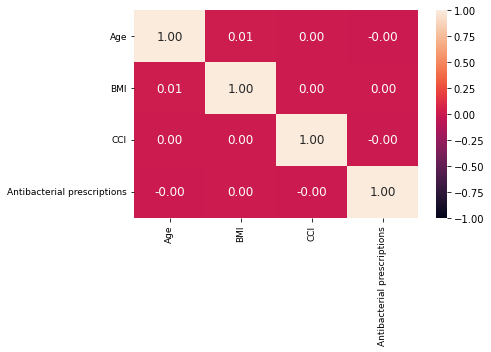

In [30]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_sinusitis[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_sinusitis/corr_sinusitis.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [31]:
data_sinusitis = data_sinusitis[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 
                                   'antibacterial_brit', 'sinusitis_ab_date', 'ab_type_cat', 'incdt_sinusitis_date', 'date', 'period',
                                   'event_sinusitis_admitted', 'duration_sinusitis_admitted'
                                    ]]

In [32]:
#switch variable sinusitis_ab_date into a binary variable
data_sinusitis[['ab_binary']] = data_sinusitis[['sinusitis_ab_date']].where(data_sinusitis[['sinusitis_ab_date']].isnull(), 1).fillna(0).astype(int)
#incident and prevalent infection 
data_sinusitis_incdt = data_sinusitis[data_sinusitis['incdt_sinusitis_date'] == 0]
data_sinusitis_prevl = data_sinusitis[data_sinusitis['incdt_sinusitis_date'] == 1]

#no antibiotics and incident hospital admission
data_sinusitis_no_abs_incdt = data_sinusitis_incdt[data_sinusitis_incdt['ab_binary'] == 0]
#with antibiotics and incident hospital admission
data_sinusitis_abs_incdt = data_sinusitis_incdt[data_sinusitis_incdt['ab_binary'] == 1]

#no antibiotics and prevalent hospital admission
data_sinusitis_no_abs_prevl = data_sinusitis_prevl[data_sinusitis_prevl['ab_binary'] == 0]
#with antibiotics and prevalent hospital admission
data_sinusitis_abs_prevl = data_sinusitis_prevl[data_sinusitis_prevl['ab_binary'] == 1]

In [33]:
##subcohorts for stratification by period
#incident and prevalent infection stratified by time period categories
data_sinusitis_incdt_prepandemic = data_sinusitis_incdt[data_sinusitis_incdt['period'] == 'prepandemic']
data_sinusitis_incdt_during_pandemic = data_sinusitis_incdt[(data_sinusitis_incdt['period'] == 'during_pandemic')]
data_sinusitis_incdt_post_2nd_lockdown = data_sinusitis_incdt[data_sinusitis_incdt['period'] == 'post_2nd_lockdown']
data_sinusitis_prevl_prepandemic = data_sinusitis_prevl[data_sinusitis_prevl['period'] == 'prepandemic']
data_sinusitis_prevl_during_pandemic = data_sinusitis_prevl[(data_sinusitis_prevl['period'] == 'during_pandemic')]
data_sinusitis_prevl_post_2nd_lockdown = data_sinusitis_prevl[data_sinusitis_prevl['period'] == 'post_2nd_lockdown']

#no antibiotics and incident hospital admission
data_sinusitis_no_abs_incdt_prepandemic = data_sinusitis_incdt_prepandemic[data_sinusitis_incdt_prepandemic['ab_binary'] == 0]
data_sinusitis_no_abs_incdt_during_pandemic = data_sinusitis_incdt_during_pandemic[data_sinusitis_incdt_during_pandemic['ab_binary'] == 0]
data_sinusitis_no_abs_incdt_post_2nd_lockdown = data_sinusitis_incdt_post_2nd_lockdown[data_sinusitis_incdt_post_2nd_lockdown['ab_binary'] == 0]
data_sinusitis_no_abs_prevl_prepandemic = data_sinusitis_prevl_prepandemic[data_sinusitis_prevl_prepandemic['ab_binary'] == 0]
data_sinusitis_no_abs_prevl_during_pandemic = data_sinusitis_prevl_during_pandemic[data_sinusitis_prevl_during_pandemic['ab_binary'] == 0]
data_sinusitis_no_abs_prevl_post_2nd_lockdown = data_sinusitis_prevl_post_2nd_lockdown[data_sinusitis_prevl_post_2nd_lockdown['ab_binary'] == 0]

In [34]:
#store data for plotting hosp admission counts and percentages
%store data_sinusitis
# save data
data_sinusitis.to_csv('../output/hospitalisation_prediction_sinusitis/data_sinusitis.csv')

Stored 'data_sinusitis' (DataFrame)


## 5- modelling of antibiotics prediction based on risk of hospital admission
### 5-0- summary tables

In [35]:
#make summary tables
make_summary_table('sinusitis', 'no_abs_incdt', data_sinusitis_no_abs_incdt)
make_summary_table('sinusitis', 'abs_incdt', data_sinusitis_abs_incdt)
make_summary_table('sinusitis', 'no_abs_prevl', data_sinusitis_no_abs_prevl)
make_summary_table('sinusitis', 'abs_prevl', data_sinusitis_abs_prevl)

### 5-1- incident

<lifelines.CoxPHFitter: fitted with 113194 total observations, 112446 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 113194
number of events observed = 748
   partial log-likelihood = -8679.53
         time fit was run = 2023-10-18 11:06:54 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.07       1.07       0.11            -0.15             0.29                 0.86                 1.33
CCI_cat[T.medium]                0.21       1.23       0.12            -0.03             0.44                 0.97                 1.56
CCI_cat[T.high]                  0.04       1.04       0.15            -0.26             0.33                 0.77                 1.39
CCI_cat[T.very_high]             0.14       1.16       0.13            -0.11             0.40                 0.90                 1.49
age_cat[T.25_34]                 0.16       1.17       0.14            -0.11             0.42                 0.89                 1.53
age_cat[T.35_44]                -0.09       0.91       0.14            -0.37             0.19                 0.69                 1.21
age_cat[T.45_54]                 0.13       1.14       0.14            -0.13             0.40                 0.88                 1.49
age_cat[T.55_64]                 0.02       1.02       0.14            -0.26             0.29                 0.77                 1.34
age_cat[T.65_74]                 0.08       1.09       0.14            -0.19             0.36                 0.83                 1.43
age_cat[T.75_more]               0.09       1.10       0.14            -0.18             0.37                 0.84                 1.44
antibacterial_brit               0.03       1.03       0.03            -0.02             0.08                 0.98                 1.09
bmi_cat[T.obese]                -0.03       0.97       0.14            -0.30             0.24                 0.74                 1.27
bmi_cat[T.overweight]           -0.04       0.96       0.17            -0.37             0.29                 0.69                 1.33
bmi_cat[T.underweight]          -0.49       0.61       0.29            -1.05             0.07                 0.35                 1.07
bmi_cat[T.unknown]               0.03       1.03       0.14            -0.25             0.31                 0.78                 1.37
ethnicity[T.other]              -0.04       0.96       0.18            -0.40             0.32                 0.67                 1.37
ethnicity[T.unknown]             0.04       1.04       0.15            -0.25             0.33                 0.78                 1.39
ethnicity[T.white]              -0.14       0.87       0.14            -0.41             0.13                 0.66                 1.14
flu_vaccine[T.yes]               0.00       1.00       0.12            -0.24             0.24                 0.79                 1.27
imd[T.medium]                   -0.12       0.88       0.11            -0.35             0.10                 0.71                 1.11
imd[T.unaffluent]               -0.10       0.90       0.11            -0.32             0.12                 0.72                 1.13
imd[T.unknown]                  -0.05       0.95       0.17            -0.40             0.29                 0.67                 1.34
imd[T.very_affluent]            -0.15       0.86       0.11            -0.38             0.07                 0.69                 1.08
imd[T.very_unaffluent]          -0.37       0.69       0.12            -0.61            -0.13                 0.55                 0.88
region[T.east_midlands]         -0.06       0.94       

13068


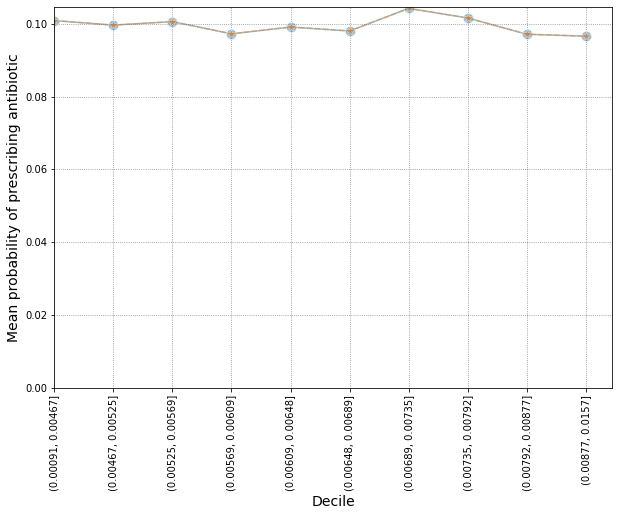


AUROC of LR for deciles with development and validation data: 0.50931 and 0.50018
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.00467, 0.00525] -0.007333       -0.089618        0.074952   
1  bins_(0.00525, 0.00569] -0.006208       -0.090870        0.078454   
2  bins_(0.00569, 0.00609] -0.053027       -0.142318        0.036264   
3  bins_(0.00609, 0.00648] -0.035145       -0.121047        0.050757   
4  bins_(0.00648, 0.00689] -0.049182       -0.133326        0.034963   
5  bins_(0.00689, 0.00735]  0.055279       -0.020684        0.131242   
6  bins_(0.00735, 0.00792]  0.011198       -0.069994        0.092389   
7  bins_(0.00792, 0.00877] -0.051604       -0.125834        0.022627   
8   bins_(0.00877, 0.0157] -0.054361       -0.142585        0.033863   

         or  or_lower_95%  or_upper_95%  
0  0.992693      0.914280      1.077832  
1  0.993811      0.913136      1.081614  
2  0.948354      0.867345      1.036930  
3  0.965465    

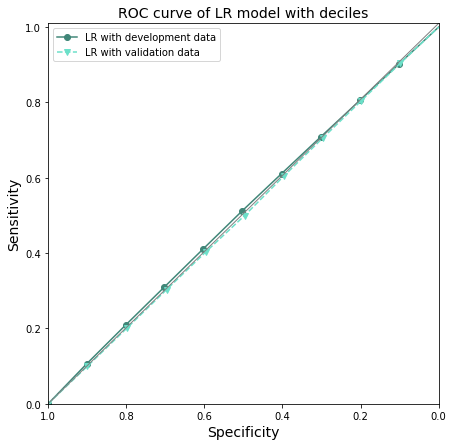

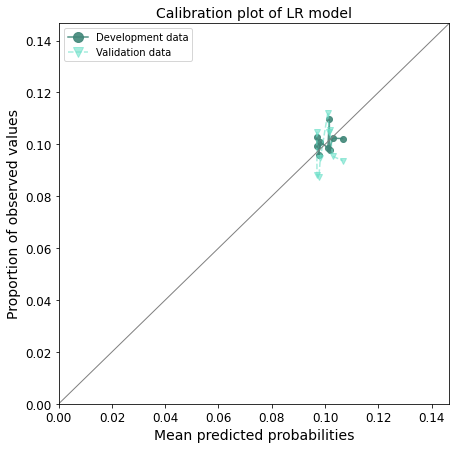


AUROC of LR for risk factors with development and validation data: 0.51302 and 0.50246
LR summary:
                       covariate      coef  coef_lower_95%  coef_upper_95%  \
0                 age_cat_25_34  0.030588       -0.040729        0.101904   
1                 age_cat_35_44  0.018689       -0.046475        0.083853   
2                 age_cat_45_54  0.031423       -0.035712        0.098558   
3                 age_cat_55_64  0.002893       -0.069939        0.075725   
4                 age_cat_65_74  0.024606       -0.042000        0.091212   
5               age_cat_75_more  0.041887       -0.033595        0.117369   
6                      sex_male  0.013602       -0.021301        0.048504   
7                  CCI_cat_high -0.000914       -0.069922        0.068095   
8                   CCI_cat_low -0.004976       -0.059077        0.049125   
9                CCI_cat_medium -0.002911       -0.067654        0.061832   
10            CCI_cat_very_high  0.002108       -0.0

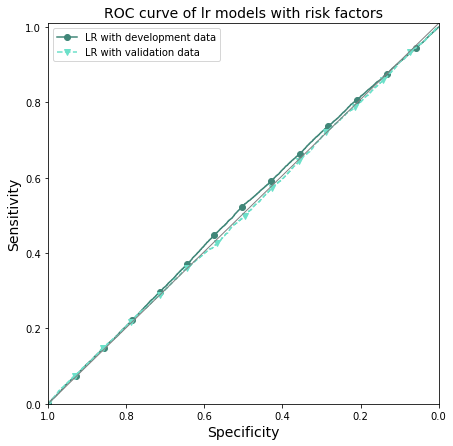

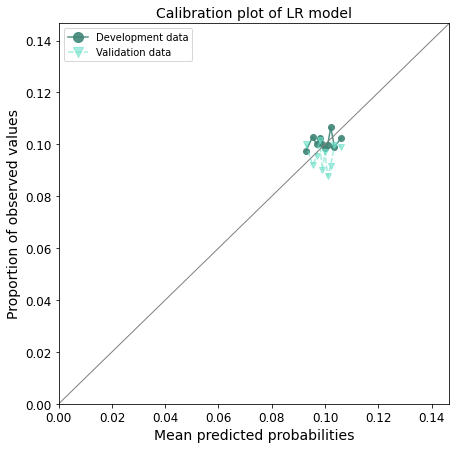

In [36]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_sinusitis_no_abs_incdt, prob_pred_sinusitis_no_abs_incdt_bin = cox_build('sinusitis', 'incdt', data_sinusitis_incdt, data_sinusitis_no_abs_incdt)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build lr models with deciles as predictors
    prob_pred_enc_lr_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt = lr_build_risk_deciles('sinusitis', 'incdt_deciles', prob_pred_sinusitis_no_abs_incdt)
    #calibration plots of lr with deciles
    calibration_lr('sinusitis', 'incdt_deciles', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt)
except:
    print("error_2: lr model for deciles did not converge or failed to finalise or their calibration plot failed.")

try:
    #build lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
    prob_pred_enc_lr_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt = lr_build_risk_riskfactors('sinusitis', 'incdt_riskfactors', prob_pred_sinusitis_no_abs_incdt)
    #calibration plots of lr with risk factors
    calibration_lr('sinusitis', 'incdt_riskfactors', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt)
except:
    print("error_3: lr model for risk factors did not converge or failed to finalise or their calibration plot failed.")

#### 5-2- prevalent

<lifelines.CoxPHFitter: fitted with 12507 total observations, 12432 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 12507
number of events observed = 75
   partial log-likelihood = -680.33
         time fit was run = 2023-10-18 11:12:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.34       0.71       0.31            -0.95             0.28                 0.39                 1.32
CCI_cat[T.medium]               -0.20       0.82       0.34            -0.86             0.47                 0.42                 1.60
CCI_cat[T.high]                 -0.48       0.62       0.45            -1.37             0.40                 0.26                 1.49
CCI_cat[T.very_high]            -0.90       0.41       0.45            -1.78            -0.02                 0.17                 0.98
age_cat[T.25_34]                 1.50       4.49       0.50             0.53             2.47                 1.70                11.88
age_cat[T.35_44]                 0.53       1.71       0.56            -0.56             1.63                 0.57                 5.10
age_cat[T.45_54]                 0.21       1.23       0.61            -0.98             1.40                 0.38                 4.04
age_cat[T.55_64]                 1.14       3.11       0.52             0.12             2.15                 1.13                 8.57
age_cat[T.65_74]                 0.42       1.51       0.59            -0.73             1.56                 0.48                 4.78
age_cat[T.75_more]               0.80       2.23       0.54            -0.26             1.86                 0.77                 6.42
antibacterial_brit              -0.15       0.86       0.09            -0.33             0.02                 0.72                 1.02
bmi_cat[T.obese]                 0.21       1.24       0.48            -0.72             1.15                 0.49                 3.15
bmi_cat[T.overweight]            0.18       1.20       0.57            -0.94             1.30                 0.39                 3.67
bmi_cat[T.underweight]           0.94       2.57       0.63            -0.30             2.19                 0.74                 8.91
bmi_cat[T.unknown]               0.12       1.13       0.51            -0.88             1.12                 0.42                 3.06
ethnicity[T.other]              -0.18       0.83       0.48            -1.12             0.75                 0.33                 2.12
ethnicity[T.unknown]            -0.71       0.49       0.41            -1.50             0.09                 0.22                 1.09
ethnicity[T.white]              -0.64       0.53       0.35            -1.34             0.06                 0.26                 1.06
flu_vaccine[T.yes]              -0.07       0.93       0.40            -0.85             0.71                 0.43                 2.04
imd[T.medium]                   -0.33       0.72       0.36            -1.04             0.38                 0.35                 1.47
imd[T.unaffluent]               -0.35       0.71       0.36            -1.06             0.37                 0.35                 1.44
imd[T.unknown]                   0.35       1.43       0.47            -0.57             1.28                 0.56                 3.60
imd[T.very_affluent]            -0.61       0.54       0.40            -1.38             0.17                 0.25                 1.18
imd[T.very_unaffluent]          -0.23       0.79       0.35            -0.92             0.46                 0.40                 1.58
region[T.east_midlands]         -0.21       0.81       0.49 

13062


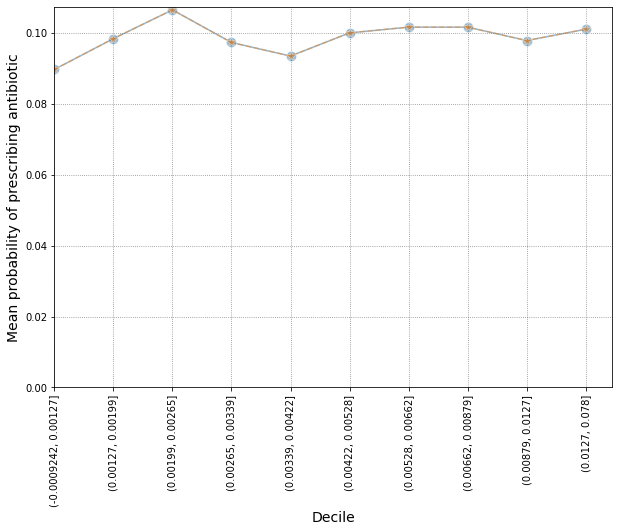


AUROC of LR for deciles with development and validation data: 0.51101 and 0.50032
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.00127, 0.00199] -0.001733       -0.235506        0.232039   
1  bins_(0.00199, 0.00265]  0.078397       -0.172903        0.329698   
2  bins_(0.00265, 0.00339] -0.023232       -0.251243        0.204779   
3  bins_(0.00339, 0.00422] -0.019595       -0.280050        0.240859   
4  bins_(0.00422, 0.00528] -0.016552       -0.296841        0.263736   
5  bins_(0.00528, 0.00662]  0.036947       -0.196328        0.270222   
6  bins_(0.00662, 0.00879]  0.052528       -0.187944        0.293000   
7   bins_(0.00879, 0.0127] -0.003847       -0.268817        0.261123   
8     bins_(0.0127, 0.078]  0.053314       -0.194576        0.301204   

         or  or_lower_95%  or_upper_95%  
0  0.998268      0.790171      1.261169  
1  1.081552      0.841219      1.390549  
2  0.977036      0.777833      1.227254  
3  0.980595    

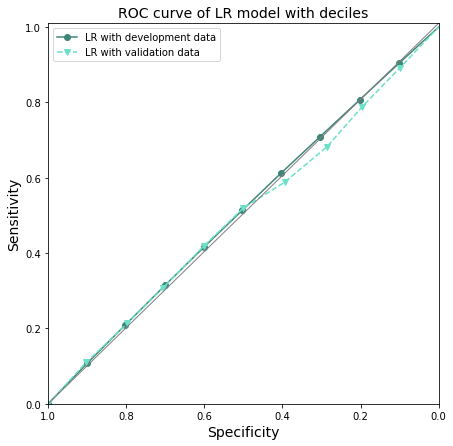

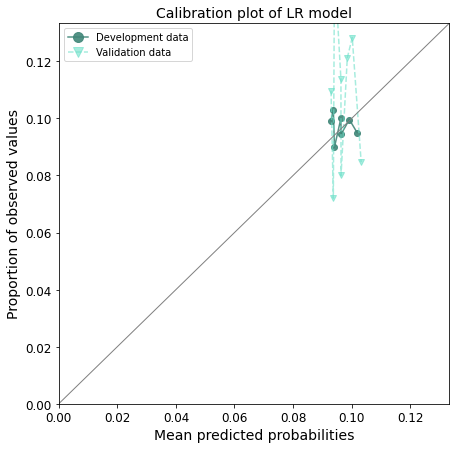


AUROC of LR for risk factors with development and validation data: 0.54835 and 0.50532
LR summary:
                       covariate      coef  coef_lower_95%  coef_upper_95%  \
0                 age_cat_25_34  0.011615       -0.182849        0.206079   
1                 age_cat_35_44  0.035914       -0.172992        0.244820   
2                 age_cat_45_54 -0.061312       -0.271858        0.149233   
3                 age_cat_55_64  0.047961       -0.166091        0.262013   
4                 age_cat_65_74  0.009971       -0.193540        0.213482   
5               age_cat_75_more  0.058588       -0.153319        0.270496   
6                      sex_male  0.098793       -0.019078        0.216664   
7                  CCI_cat_high -0.242894       -0.440396       -0.045392   
8                   CCI_cat_low -0.110969       -0.265425        0.043487   
9                CCI_cat_medium -0.072235       -0.239845        0.095374   
10            CCI_cat_very_high -0.010363       -0.1

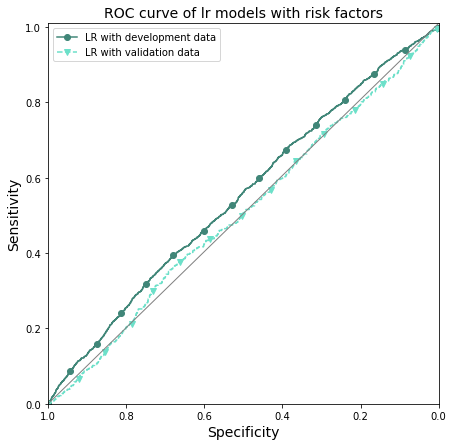

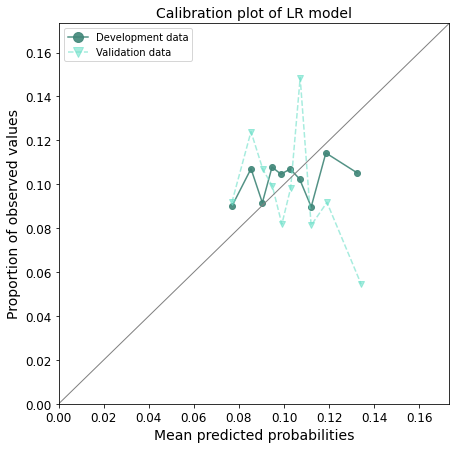

In [37]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_sinusitis_no_abs_prevl, prob_pred_sinusitis_no_abs_prevl_bin = cox_build('sinusitis', 'prevl', data_sinusitis_prevl, data_sinusitis_no_abs_prevl)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build lr models with deciles as predictors
    prob_pred_enc_lr_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl = lr_build_risk_deciles('sinusitis', 'prevl_deciles', prob_pred_sinusitis_no_abs_prevl)
    #calibration plots of lr with deciles
    calibration_lr('sinusitis', 'prevl_deciles', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl)
except:
    print("error_2: lr model for deciles did not converge or failed to finalise or their calibration plot failed.")

try:
    #build lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
    prob_pred_enc_lr_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl = lr_build_risk_riskfactors('sinusitis', 'prevl_riskfactors', prob_pred_sinusitis_no_abs_prevl)
    #calibration plots of lr with risk factors
    calibration_lr('sinusitis', 'prevl_riskfactors', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl)
except:
    print("error_3: lr model for risk factors did not converge or failed to finalise or their calibration plot failed.")

#### 5-3- stratification by time period
#### 5-3-1- incident

<lifelines.CoxPHFitter: fitted with 28560 total observations, 28396 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 28560
number of events observed = 164
   partial log-likelihood = -1660.82
         time fit was run = 2023-10-18 11:12:35 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.41       0.66       0.22            -0.84             0.01                 0.43                 1.01
CCI_cat[T.medium]               -0.33       0.72       0.24            -0.81             0.14                 0.44                 1.15
CCI_cat[T.high]                 -0.28       0.76       0.29            -0.85             0.29                 0.43                 1.33
CCI_cat[T.very_high]            -0.29       0.75       0.25            -0.79             0.21                 0.45                 1.23
age_cat[T.25_34]                 0.30       1.35       0.30            -0.28             0.88                 0.76                 2.40
age_cat[T.35_44]                 0.13       1.14       0.31            -0.47             0.73                 0.62                 2.07
age_cat[T.45_54]                 0.30       1.35       0.29            -0.27             0.88                 0.76                 2.40
age_cat[T.55_64]                 0.07       1.07       0.31            -0.54             0.67                 0.58                 1.96
age_cat[T.65_74]                 0.08       1.08       0.31            -0.53             0.69                 0.59                 1.99
age_cat[T.75_more]               0.07       1.08       0.31            -0.53             0.68                 0.59                 1.97
antibacterial_brit               0.02       1.02       0.05            -0.08             0.13                 0.92                 1.14
bmi_cat[T.obese]                -0.30       0.74       0.26            -0.81             0.21                 0.44                 1.23
bmi_cat[T.overweight]           -0.90       0.40       0.39            -1.68            -0.13                 0.19                 0.88
bmi_cat[T.underweight]          -0.56       0.57       0.55            -1.64             0.53                 0.19                 1.70
bmi_cat[T.unknown]              -0.17       0.85       0.28            -0.71             0.38                 0.49                 1.46
ethnicity[T.other]               0.25       1.28       0.38            -0.50             1.00                 0.61                 2.71
ethnicity[T.unknown]             0.10       1.10       0.33            -0.54             0.74                 0.58                 2.09
ethnicity[T.white]              -0.06       0.94       0.31            -0.67             0.54                 0.51                 1.71
flu_vaccine[T.yes]              -0.02       0.98       0.26            -0.54             0.50                 0.59                 1.64
imd[T.medium]                   -0.14       0.87       0.26            -0.65             0.37                 0.52                 1.45
imd[T.unaffluent]               -0.04       0.96       0.25            -0.53             0.45                 0.59                 1.58
imd[T.unknown]                  -0.18       0.84       0.42            -0.99             0.64                 0.37                 1.90
imd[T.very_affluent]             0.24       1.27       0.24            -0.22             0.71                 0.80                 2.03
imd[T.very_unaffluent]          -0.25       0.78       0.27            -0.77             0.28                 0.46                 1.32
region[T.east_midlands]         -0.61       0.54       0.3

13070


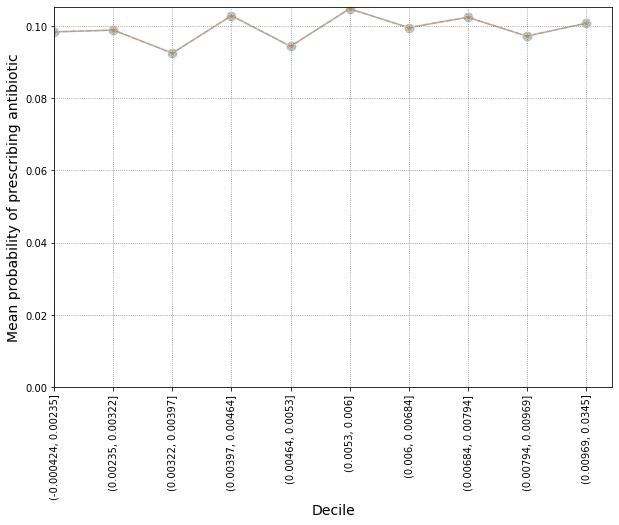


AUROC of LR for deciles with development and validation data: 0.51191 and 0.49964
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.00235, 0.00322]  0.026432       -0.116620        0.169485   
1  bins_(0.00322, 0.00397] -0.055815       -0.213923        0.102292   
2  bins_(0.00397, 0.00464]  0.028010       -0.127493        0.183513   
3   bins_(0.00464, 0.0053] -0.006173       -0.161300        0.148953   
4     bins_(0.0053, 0.006]  0.039986       -0.121532        0.201504   
5    bins_(0.006, 0.00684] -0.018133       -0.187163        0.150897   
6  bins_(0.00684, 0.00794]  0.081241       -0.081223        0.243704   
7  bins_(0.00794, 0.00969] -0.021823       -0.167486        0.123839   
8   bins_(0.00969, 0.0345]  0.069596       -0.075928        0.215120   

         or  or_lower_95%  or_upper_95%  
0  1.026784      0.889923      1.184694  
1  0.945714      0.807411      1.107706  
2  1.028406      0.880299      1.201430  
3  0.993846    

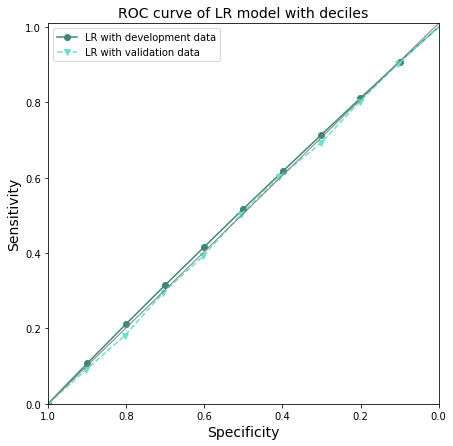

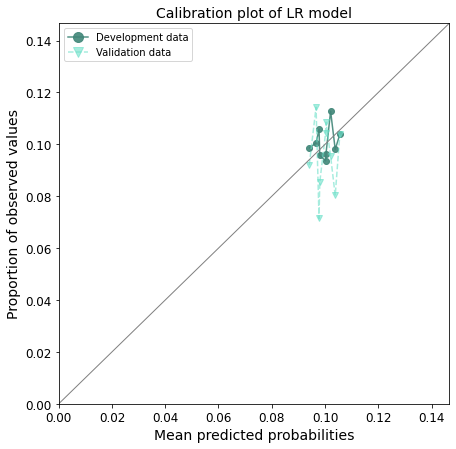

In [38]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_sinusitis_no_abs_incdt_prepandemic, prob_pred_sinusitis_no_abs_incdt_prepandemic_bin = cox_build('sinusitis', 'incdt_prepandemic', data_sinusitis_incdt_prepandemic, data_sinusitis_no_abs_incdt_prepandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build lr models
    prob_pred_enc_lr_incdt_prepandemic, data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic = lr_build_risk_deciles('sinusitis', 'incdt_prepandemic_deciles', prob_pred_sinusitis_no_abs_incdt_prepandemic)
    #calibration plots of lr
    calibration_lr('sinusitis', 'incdt_prepandemic', data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic)
except:
    print("error_2: lr model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 26143 total observations, 25989 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 26143
number of events observed = 154
   partial log-likelihood = -1548.39
         time fit was run = 2023-10-18 11:12:48 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.35       0.71       0.23            -0.79             0.10                 0.45                 1.10
CCI_cat[T.medium]               -0.28       0.75       0.25            -0.78             0.21                 0.46                 1.23
CCI_cat[T.high]                 -0.56       0.57       0.34            -1.22             0.10                 0.29                 1.11
CCI_cat[T.very_high]            -0.02       0.98       0.25            -0.51             0.46                 0.60                 1.59
age_cat[T.25_34]                 0.00       1.00       0.30            -0.59             0.59                 0.55                 1.81
age_cat[T.35_44]                -0.06       0.94       0.31            -0.66             0.54                 0.52                 1.72
age_cat[T.45_54]                 0.13       1.14       0.29            -0.44             0.71                 0.64                 2.02
age_cat[T.55_64]                -0.35       0.71       0.33            -0.99             0.30                 0.37                 1.35
age_cat[T.65_74]                 0.16       1.17       0.29            -0.41             0.73                 0.67                 2.07
age_cat[T.75_more]               0.04       1.04       0.30            -0.55             0.63                 0.58                 1.89
antibacterial_brit               0.06       1.06       0.06            -0.05             0.17                 0.95                 1.19
bmi_cat[T.obese]                 0.24       1.28       0.34            -0.41             0.90                 0.66                 2.46
bmi_cat[T.overweight]           -0.12       0.88       0.43            -0.96             0.72                 0.38                 2.04
bmi_cat[T.underweight]           0.63       1.88       0.49            -0.34             1.60                 0.72                 4.95
bmi_cat[T.unknown]               0.39       1.47       0.35            -0.30             1.07                 0.74                 2.92
ethnicity[T.other]               0.41       1.50       0.46            -0.49             1.30                 0.61                 3.67
ethnicity[T.unknown]             0.43       1.54       0.39            -0.33             1.19                 0.72                 3.28
ethnicity[T.white]               0.36       1.44       0.37            -0.36             1.09                 0.70                 2.96
flu_vaccine[T.yes]               0.26       1.29       0.25            -0.23             0.74                 0.80                 2.09
imd[T.medium]                   -0.11       0.90       0.27            -0.63             0.41                 0.53                 1.51
imd[T.unaffluent]                0.15       1.16       0.25            -0.34             0.63                 0.71                 1.89
imd[T.unknown]                   0.37       1.45       0.34            -0.30             1.04                 0.74                 2.84
imd[T.very_affluent]            -0.15       0.86       0.27            -0.67             0.38                 0.51                 1.46
imd[T.very_unaffluent]          -0.23       0.80       0.27            -0.76             0.31                 0.47                 1.37
region[T.east_midlands]         -0.15       0.86       0.3

13063


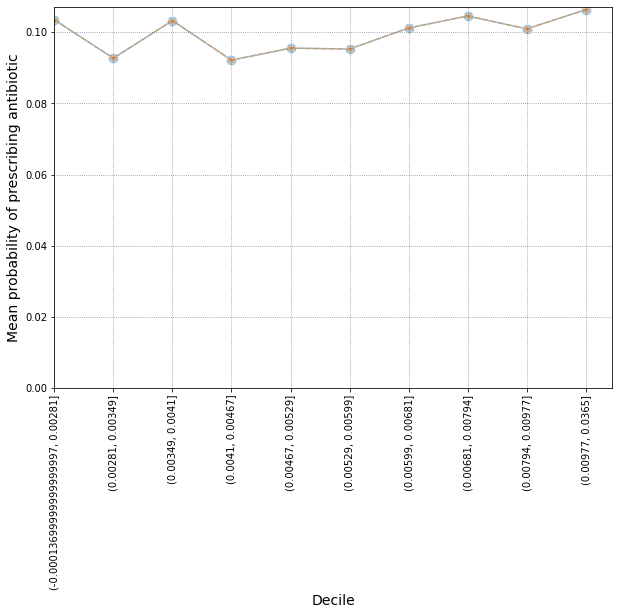


AUROC of LR for deciles with development and validation data: 0.52196 and 0.49329
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.00281, 0.00349] -0.136427       -0.305488        0.032633   
1   bins_(0.00349, 0.0041] -0.018189       -0.175663        0.139284   
2   bins_(0.0041, 0.00467] -0.188319       -0.369480       -0.007159   
3  bins_(0.00467, 0.00529] -0.166691       -0.354130        0.020749   
4  bins_(0.00529, 0.00599] -0.154576       -0.321529        0.012376   
5  bins_(0.00599, 0.00681] -0.029862       -0.194937        0.135214   
6  bins_(0.00681, 0.00794] -0.026427       -0.187076        0.134221   
7  bins_(0.00794, 0.00977] -0.100718       -0.277947        0.076511   
8   bins_(0.00977, 0.0365]  0.041587       -0.107044        0.190218   

         or  or_lower_95%  or_upper_95%  
0  0.872470      0.736764      1.033172  
1  0.981975      0.838900      1.149451  
2  0.828350      0.691094      0.992867  
3  0.846461    

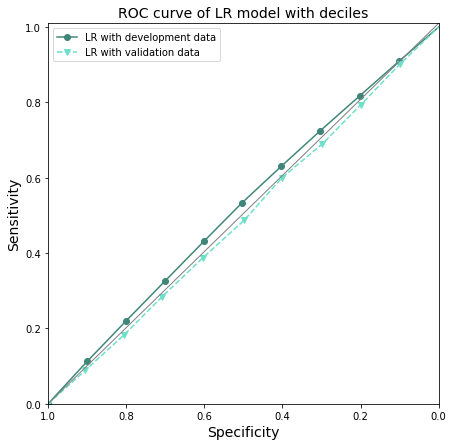

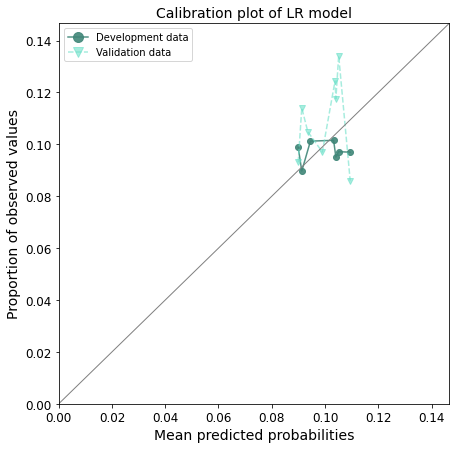

In [39]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_sinusitis_no_abs_incdt_during_pandemic, prob_pred_sinusitis_no_abs_incdt_during_pandemic_bin = cox_build('sinusitis', 'incdt_during_pandemic', data_sinusitis_incdt_during_pandemic, data_sinusitis_no_abs_incdt_during_pandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build lr models
    prob_pred_enc_lr_incdt_during_pandemic, data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic = lr_build_risk_deciles('sinusitis', 'incdt_during_pandemic_deciles', prob_pred_sinusitis_no_abs_incdt_during_pandemic)
    #calibration plots of lr
    calibration_lr('sinusitis', 'incdt_during_pandemic', data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic)
except:
    print("error_2: lr model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 49458 total observations, 49109 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 49458
number of events observed = 349
   partial log-likelihood = -3737.19
         time fit was run = 2023-10-18 11:13:01 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.35       1.43       0.17             0.01             0.70                 1.01                 2.00
CCI_cat[T.medium]                0.47       1.61       0.18             0.11             0.84                 1.12                 2.30
CCI_cat[T.high]                  0.13       1.14       0.23            -0.33             0.58                 0.72                 1.79
CCI_cat[T.very_high]             0.11       1.12       0.21            -0.29             0.52                 0.75                 1.68
age_cat[T.25_34]                 0.01       1.01       0.20            -0.39             0.41                 0.68                 1.50
age_cat[T.35_44]                -0.28       0.76       0.22            -0.70             0.15                 0.50                 1.16
age_cat[T.45_54]                -0.18       0.84       0.21            -0.59             0.24                 0.56                 1.27
age_cat[T.55_64]                 0.01       1.01       0.20            -0.39             0.40                 0.68                 1.49
age_cat[T.65_74]                 0.19       1.21       0.19            -0.19             0.57                 0.83                 1.77
age_cat[T.75_more]               0.20       1.22       0.19            -0.18             0.58                 0.83                 1.78
antibacterial_brit               0.06       1.06       0.04            -0.01             0.13                 0.99                 1.14
bmi_cat[T.obese]                -0.05       0.95       0.20            -0.44             0.33                 0.64                 1.39
bmi_cat[T.overweight]            0.17       1.19       0.23            -0.28             0.63                 0.76                 1.87
bmi_cat[T.underweight]          -1.38       0.25       0.61            -2.56            -0.19                 0.08                 0.83
bmi_cat[T.unknown]              -0.06       0.94       0.21            -0.48             0.35                 0.62                 1.42
ethnicity[T.other]              -0.35       0.71       0.27            -0.88             0.18                 0.42                 1.20
ethnicity[T.unknown]            -0.00       1.00       0.20            -0.39             0.39                 0.67                 1.48
ethnicity[T.white]              -0.37       0.69       0.19            -0.75             0.00                 0.47                 1.00
flu_vaccine[T.yes]               0.08       1.08       0.17            -0.26             0.42                 0.77                 1.52
imd[T.medium]                   -0.24       0.79       0.17            -0.57             0.10                 0.56                 1.10
imd[T.unaffluent]               -0.17       0.85       0.17            -0.49             0.16                 0.61                 1.18
imd[T.unknown]                  -0.05       0.95       0.25            -0.54             0.44                 0.58                 1.55
imd[T.very_affluent]            -0.07       0.93       0.16            -0.39             0.25                 0.68                 1.28
imd[T.very_unaffluent]          -0.40       0.67       0.18            -0.75            -0.04                 0.47                 0.96
region[T.east_midlands]          0.36       1.43       0.2

13058


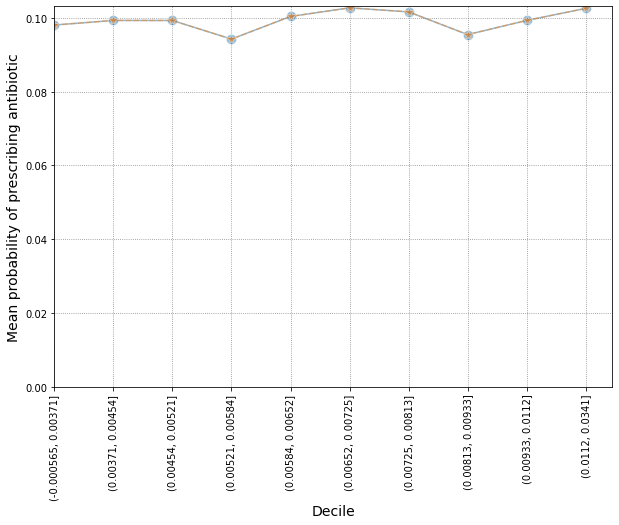


AUROC of LR for deciles with development and validation data: 0.51295 and 0.48938
LR summary:
                  covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.00371, 0.00454]  0.013360       -0.120213        0.146934   
1  bins_(0.00454, 0.00521]  0.063717       -0.063483        0.190917   
2  bins_(0.00521, 0.00584] -0.039468       -0.154661        0.075724   
3  bins_(0.00584, 0.00652]  0.028825       -0.094120        0.151770   
4  bins_(0.00652, 0.00725]  0.046369       -0.080993        0.173731   
5  bins_(0.00725, 0.00813]  0.106723       -0.009232        0.222679   
6  bins_(0.00813, 0.00933]  0.007971       -0.126020        0.141962   
7   bins_(0.00933, 0.0112]  0.026663       -0.085034        0.138361   
8    bins_(0.0112, 0.0341]  0.109526       -0.008970        0.228023   

         or  or_lower_95%  or_upper_95%  
0  1.013450      0.886731      1.158277  
1  1.065791      0.938490      1.210360  
2  0.961300      0.856706      1.078665  
3  1.029244    

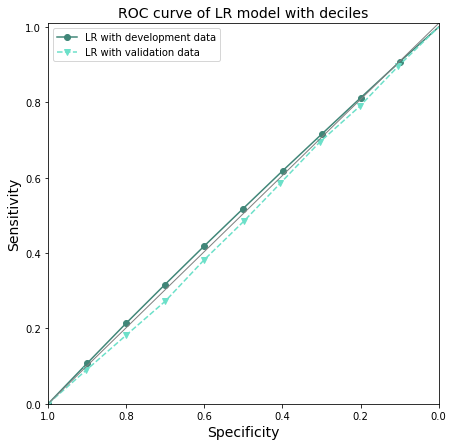

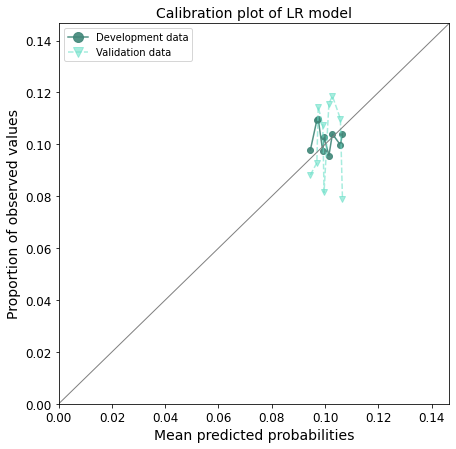

In [40]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_sinusitis_no_abs_incdt_post_2nd_lockdown, prob_pred_sinusitis_no_abs_incdt_post_2nd_lockdown_bin = cox_build('sinusitis', 'incdt_post_2nd_lockdown', data_sinusitis_incdt_post_2nd_lockdown, data_sinusitis_no_abs_incdt_post_2nd_lockdown)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build lr models
    prob_pred_enc_lr_incdt_post_2nd_lockdown, data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown = lr_build_risk_deciles('sinusitis', 'incdt_post_2nd_lockdown_deciles', prob_pred_sinusitis_no_abs_incdt_post_2nd_lockdown)
    #calibration plots of lr
    calibration_lr('sinusitis', 'incdt_post_2nd_lockdown', data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown)
except:
    print("error_2: lr model for deciles did not converge or failed to finalise or their calibration plot failed.")

#### 5-3-2- prevalent

<lifelines.CoxPHFitter: fitted with 3174 total observations, 3154 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 3174
number of events observed = 20
   partial log-likelihood = -141.81
         time fit was run = 2023-10-18 11:13:24 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.51       1.67       0.67            -0.79             1.82                 0.45                 6.16
CCI_cat[T.medium]               -0.41       0.66       0.82            -2.03             1.20                 0.13                 3.33
CCI_cat[T.high]                  0.42       1.51       0.83            -1.21             2.04                 0.30                 7.71
CCI_cat[T.very_high]            -1.01       0.36       1.16            -3.29             1.26                 0.04                 3.54
age_cat[T.25_34]                 1.28       3.61       0.83            -0.35             2.91                 0.71                18.38
age_cat[T.35_44]                 0.03       1.03       1.01            -1.96             2.01                 0.14                 7.48
age_cat[T.45_54]                -0.76       0.47       1.23            -3.18             1.66                 0.04                 5.27
age_cat[T.55_64]                 0.37       1.45       0.93            -1.45             2.20                 0.23                 9.00
age_cat[T.65_74]                 0.70       2.01       0.88            -1.03             2.42                 0.36                11.23
age_cat[T.75_more]               0.11       1.12       1.01            -1.88             2.09                 0.15                 8.13
antibacterial_brit              -0.13       0.88       0.17            -0.47             0.20                 0.63                 1.23
bmi_cat[T.obese]                -0.31       0.73       0.78            -1.84             1.23                 0.16                 3.41
bmi_cat[T.overweight]          -18.38       0.00    5358.06        -10519.99         10483.22                 0.00                  inf
bmi_cat[T.underweight]           1.11       3.02       1.04            -0.93             3.14                 0.40                23.06
bmi_cat[T.unknown]              -0.34       0.71       0.85            -2.01             1.34                 0.13                 3.81
ethnicity[T.other]              -0.55       0.58       1.24            -2.98             1.88                 0.05                 6.55
ethnicity[T.unknown]            -0.79       0.45       0.93            -2.61             1.03                 0.07                 2.80
ethnicity[T.white]              -0.14       0.87       0.77            -1.65             1.38                 0.19                 3.97
flu_vaccine[T.yes]               0.83       2.30       0.58            -0.29             1.96                 0.74                 7.12
imd[T.medium]                   -1.23       0.29       1.13            -3.43             0.98                 0.03                 2.66
imd[T.unaffluent]                0.12       1.12       0.72            -1.30             1.53                 0.27                 4.64
imd[T.unknown]                 -17.94       0.00    7833.70        -15371.71         15335.83                 0.00                  inf
imd[T.very_affluent]             0.52       1.68       0.66            -0.77             1.81                 0.46                 6.14
imd[T.very_unaffluent]           0.33       1.39       0.69            -1.03             1.68                 0.36                 5.38
region[T.east_midlands]         -0.66       0.51       1.23    

13135


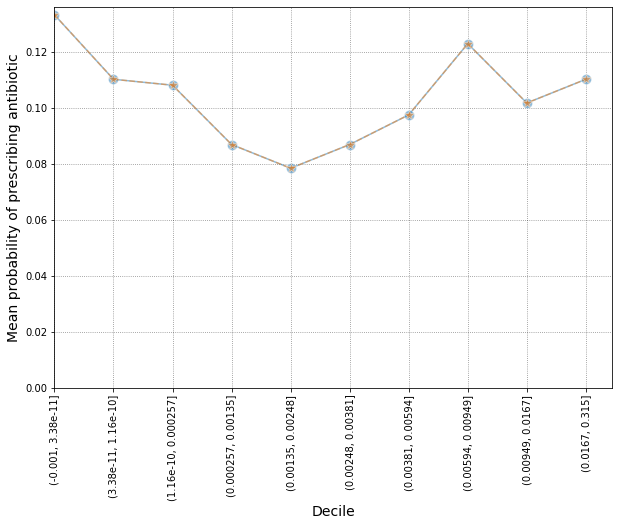


AUROC of LR for deciles with development and validation data: 0.55621 and 0.52297
LR summary:
                    covariate      coef  coef_lower_95%  coef_upper_95%  \
0   bins_(0.000257, 0.00135] -0.394432       -0.847538        0.058673   
1    bins_(0.00135, 0.00248] -0.618745       -0.997532       -0.239957   
2    bins_(0.00248, 0.00381] -0.572879       -1.040078       -0.105681   
3    bins_(0.00381, 0.00594] -0.318487       -0.724955        0.087981   
4    bins_(0.00594, 0.00949] -0.057736       -0.444476        0.329003   
5     bins_(0.00949, 0.0167] -0.342122       -0.799813        0.115570   
6       bins_(0.0167, 0.315] -0.186514       -0.567169        0.194142   
7  bins_(1.16e-10, 0.000257] -0.215165       -0.610548        0.180218   
8  bins_(3.38e-11, 1.16e-10] -0.278074       -0.707404        0.151256   

         or  or_lower_95%  or_upper_95%  
0  0.674063      0.428469      1.060429  
1  0.538620      0.368788      0.786662  
2  0.563899      0.353427      0.8997

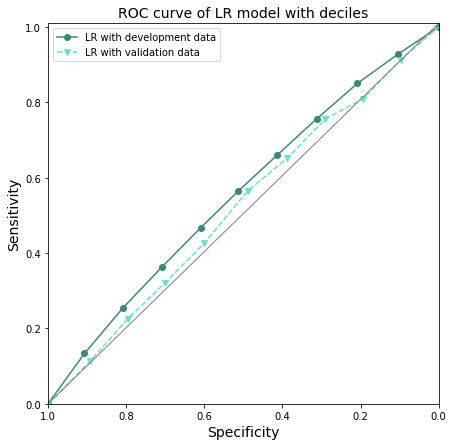

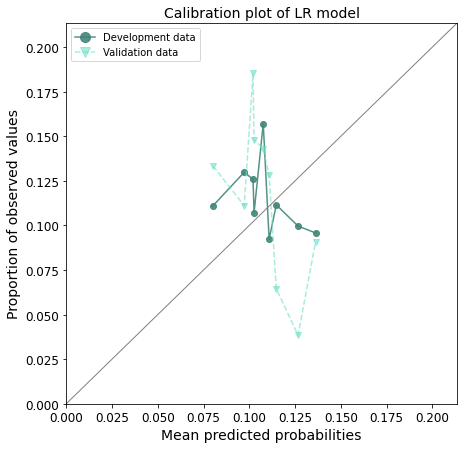

In [41]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_sinusitis_no_abs_prevl_prepandemic, prob_pred_sinusitis_no_abs_prevl_prepandemic_bin = cox_build('sinusitis', 'prevl_prepandemic', data_sinusitis_prevl_prepandemic, data_sinusitis_no_abs_prevl_prepandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build lr models
    prob_pred_enc_lr_prevl_prepandemic, data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic = lr_build_risk_deciles('sinusitis', 'prevl_prepandemic_deciles', prob_pred_sinusitis_no_abs_prevl_prepandemic)
    #calibration plots of lr
    calibration_lr('sinusitis', 'prevl_prepandemic', data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic)
except:
    print("error_2: lr model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 2943 total observations, 2930 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 2943
number of events observed = 13
   partial log-likelihood = -81.93
         time fit was run = 2023-10-18 11:13:29 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.35       0.71       0.89            -2.09             1.39                 0.12                 4.03
CCI_cat[T.medium]                0.54       1.72       0.86            -1.15             2.23                 0.32                 9.34
CCI_cat[T.high]                  0.09       1.09       1.04            -1.95             2.12                 0.14                 8.33
CCI_cat[T.very_high]           -18.15       0.00    5620.44        -11034.00         10997.70                 0.00                  inf
age_cat[T.25_34]                 1.79       5.98       1.11            -0.40             3.97                 0.67                53.03
age_cat[T.35_44]               -17.58       0.00    6719.50        -13187.55         13152.40                 0.00                  inf
age_cat[T.45_54]                 0.70       2.01       1.25            -1.74             3.14                 0.17                23.04
age_cat[T.55_64]                 0.14       1.15       1.43            -2.66             2.94                 0.07                18.91
age_cat[T.65_74]                 1.42       4.12       1.17            -0.88             3.72                 0.41                41.11
age_cat[T.75_more]               0.26       1.30       1.43            -2.54             3.06                 0.08                21.40
antibacterial_brit               0.02       1.02       0.20            -0.37             0.41                 0.69                 1.50
bmi_cat[T.obese]                18.32   9.08e+07    9044.63        -17708.83         17745.48                 0.00                  inf
bmi_cat[T.overweight]           17.83   5.56e+07    9044.63        -17709.32         17744.99                 0.00                  inf
bmi_cat[T.underweight]           0.26       1.29   16123.14        -31600.51         31601.03                 0.00                  inf
bmi_cat[T.unknown]              18.30   8.82e+07    9044.63        -17708.86         17745.45                 0.00                  inf
ethnicity[T.other]              -0.74       0.48       1.26            -3.19             1.72                 0.04                 5.61
ethnicity[T.unknown]            -0.53       0.59       0.94            -2.38             1.31                 0.09                 3.69
ethnicity[T.white]              -0.63       0.54       0.82            -2.24             0.99                 0.11                 2.69
flu_vaccine[T.yes]               0.07       1.07       1.09            -2.07             2.21                 0.13                 9.09
imd[T.medium]                    0.14       1.15       0.84            -1.50             1.79                 0.22                 5.98
imd[T.unaffluent]               -0.97       0.38       1.18            -3.28             1.34                 0.04                 3.82
imd[T.unknown]                   0.13       1.14       1.20            -2.21             2.48                 0.11                11.93
imd[T.very_affluent]            -0.06       0.94       0.87            -1.77             1.64                 0.17                 5.14
imd[T.very_unaffluent]          -0.29       0.75       0.94            -2.13             1.55                 0.12                 4.72
region[T.east_midlands]         17.98   6.42e+07    8170.94     

13272


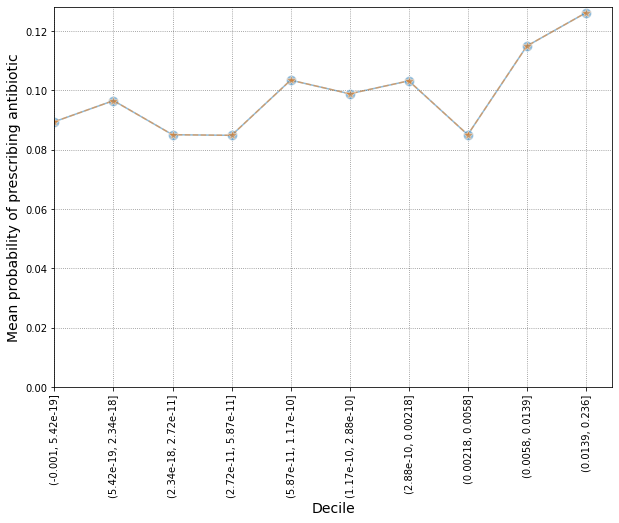


AUROC of LR for deciles with development and validation data: 0.56240 and 0.46939
LR summary:
                    covariate      coef  coef_lower_95%  coef_upper_95%  \
0     bins_(0.00218, 0.0058] -0.071141       -0.533652        0.391370   
1      bins_(0.0058, 0.0139]  0.346174       -0.028275        0.720623   
2       bins_(0.0139, 0.236]  0.477464        0.035412        0.919516   
3  bins_(1.17e-10, 2.88e-10]  0.178002       -0.284337        0.640341   
4  bins_(2.34e-18, 2.72e-11] -0.140426       -0.618772        0.337920   
5  bins_(2.72e-11, 5.87e-11] -0.333305       -0.826292        0.159681   
6   bins_(2.88e-10, 0.00218]  0.085571       -0.360953        0.532095   
7  bins_(5.42e-19, 2.34e-18]  0.157725       -0.272983        0.588433   
8  bins_(5.87e-11, 1.17e-10]  0.197336       -0.241165        0.635838   

         or  or_lower_95%  or_upper_95%  
0  0.931330      0.586459      1.479005  
1  1.413649      0.972121      2.055715  
2  1.611981      1.036046      2.5080

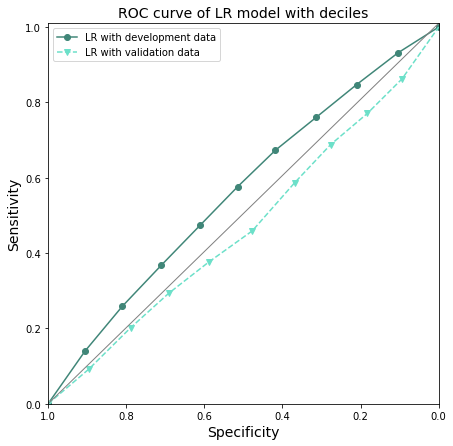

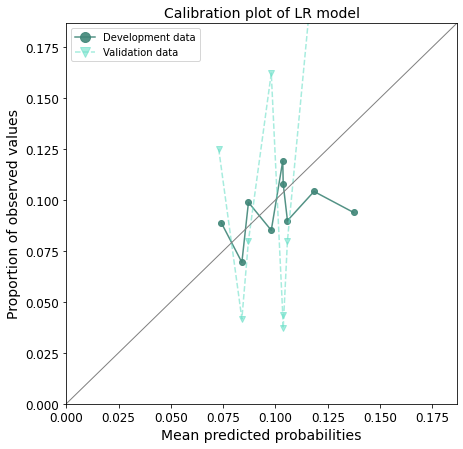

In [42]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_sinusitis_no_abs_prevl_during_pandemic, prob_pred_sinusitis_no_abs_prevl_during_pandemic_bin = cox_build('sinusitis', 'prevl_during_pandemic', data_sinusitis_prevl_during_pandemic, data_sinusitis_no_abs_prevl_during_pandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build lr models
    prob_pred_enc_lr_prevl_during_pandemic, data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic = lr_build_risk_deciles('sinusitis', 'prevl_during_pandemic_deciles', prob_pred_sinusitis_no_abs_prevl_during_pandemic)
    #calibration plots of lr
    calibration_lr('sinusitis', 'prevl_during_pandemic', data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic)
except:
    print("error_2: lr model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 5367 total observations, 5338 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 5367
number of events observed = 29
   partial log-likelihood = -228.73
         time fit was run = 2023-10-18 11:13:34 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.29       0.75       0.49            -1.24             0.67                 0.29                 1.95
CCI_cat[T.medium]               -0.44       0.64       0.56            -1.54             0.66                 0.21                 1.93
CCI_cat[T.high]                 -0.05       0.95       0.63            -1.29             1.19                 0.28                 3.29
CCI_cat[T.very_high]            -1.94       0.14       1.07            -4.04             0.16                 0.02                 1.17
age_cat[T.25_34]                 1.54       4.65       0.78             0.00             3.08                 1.00                21.66
age_cat[T.35_44]                -0.01       0.99       1.00            -1.98             1.96                 0.14                 7.07
age_cat[T.45_54]                 0.04       1.05       1.00            -1.92             2.01                 0.15                 7.47
age_cat[T.55_64]                 1.00       2.71       0.84            -0.65             2.65                 0.52                14.09
age_cat[T.65_74]                 0.47       1.60       0.92            -1.33             2.26                 0.26                 9.63
age_cat[T.75_more]               1.14       3.12       0.82            -0.47             2.75                 0.62                15.65
antibacterial_brit              -0.18       0.83       0.14            -0.46             0.10                 0.63                 1.10
bmi_cat[T.obese]                 0.24       1.27       0.76            -1.25             1.72                 0.29                 5.60
bmi_cat[T.overweight]            0.54       1.72       0.87            -1.17             2.25                 0.31                 9.48
bmi_cat[T.underweight]           0.95       2.58       1.01            -1.04             2.93                 0.35                18.78
bmi_cat[T.unknown]               0.06       1.06       0.82            -1.55             1.68                 0.21                 5.34
ethnicity[T.other]               0.30       1.36       0.77            -1.21             1.82                 0.30                 6.15
ethnicity[T.unknown]            -0.55       0.58       0.71            -1.94             0.85                 0.14                 2.34
ethnicity[T.white]              -0.43       0.65       0.63            -1.68             0.81                 0.19                 2.26
flu_vaccine[T.yes]              -0.06       0.94       0.62            -1.27             1.15                 0.28                 3.16
imd[T.medium]                   -0.37       0.69       0.50            -1.35             0.61                 0.26                 1.84
imd[T.unaffluent]               -1.22       0.30       0.66            -2.52             0.08                 0.08                 1.08
imd[T.unknown]                  -0.25       0.78       0.78            -1.78             1.28                 0.17                 3.61
imd[T.very_affluent]            -1.67       0.19       0.78            -3.20            -0.15                 0.04                 0.86
imd[T.very_unaffluent]          -0.82       0.44       0.55            -1.90             0.27                 0.15                 1.30
region[T.east_midlands]          0.61       1.84       0.87    

13091


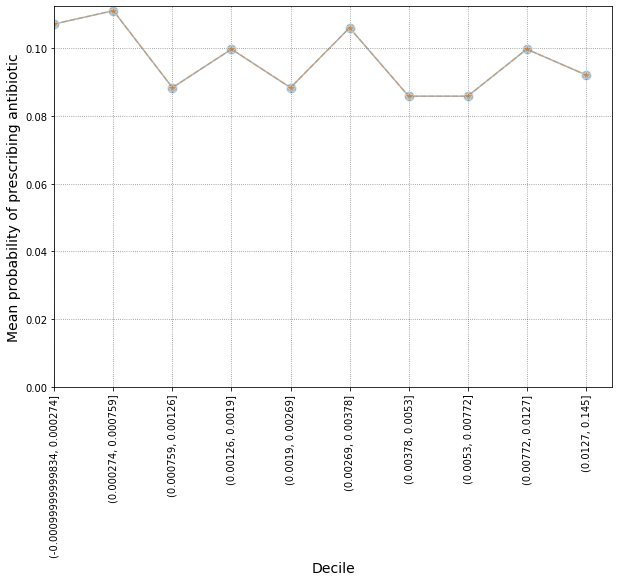


AUROC of LR for deciles with development and validation data: 0.53629 and 0.48698
LR summary:
                    covariate      coef  coef_lower_95%  coef_upper_95%  \
0  bins_(0.000274, 0.000759]  0.045162       -0.362152        0.452477   
1   bins_(0.000759, 0.00126] -0.285182       -0.688053        0.117689   
2     bins_(0.00126, 0.0019] -0.096829       -0.451482        0.257825   
3     bins_(0.0019, 0.00269] -0.066008       -0.441396        0.309380   
4    bins_(0.00269, 0.00378]  0.100561       -0.270497        0.471620   
5     bins_(0.00378, 0.0053] -0.237889       -0.607209        0.131431   
6     bins_(0.0053, 0.00772] -0.176078       -0.528630        0.176475   
7     bins_(0.00772, 0.0127]  0.006375       -0.346913        0.359662   
8       bins_(0.0127, 0.145] -0.209774       -0.556305        0.136757   

         or  or_lower_95%  or_upper_95%  
0  1.046198      0.696177      1.572202  
1  0.751877      0.502553      1.124894  
2  0.907712      0.636684      1.2941

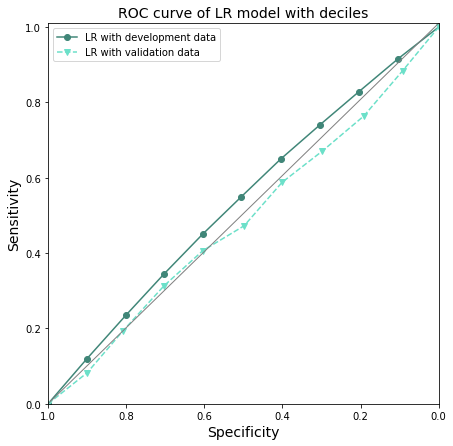

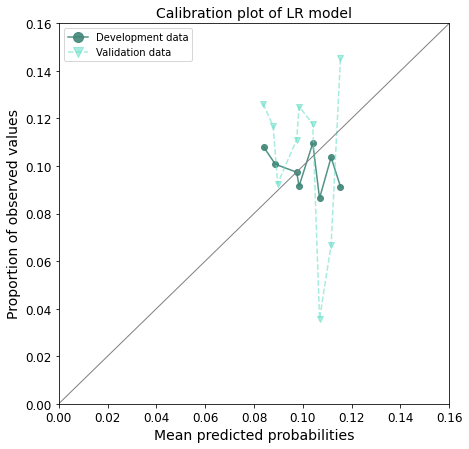

In [43]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_sinusitis_no_abs_prevl_post_2nd_lockdown, prob_pred_sinusitis_no_abs_prevl_post_2nd_lockdown_bin = cox_build('sinusitis', 'prevl_post_2nd_lockdown', data_sinusitis_prevl_post_2nd_lockdown, data_sinusitis_no_abs_prevl_post_2nd_lockdown)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build lr models
    prob_pred_enc_lr_prevl_post_2nd_lockdown, data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown = lr_build_risk_deciles('sinusitis', 'prevl_post_2nd_lockdown_deciles', prob_pred_sinusitis_no_abs_prevl_post_2nd_lockdown)
    #calibration plots of lr
    calibration_lr('sinusitis', 'prevl_post_2nd_lockdown', data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown)
except:
    print("error_2: lr model for deciles did not converge or failed to finalise or their calibration plot failed.")